# System wykrywania spamu w wiadomościach e-mail

W tym notebooku wczytujemy dane - przykładowe e-maile klasyfikowane jako spam lub nie-spam. Na podstawie tych danych trenujemy system, który będzie wykrywał, czy dana wiadomość jest spamem czy nie.

Zacznijmy od zainstalowania wymaganych bibliotek.

In [2]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Następnie importujemy potrzebne moduły.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import keras_tuner as kt
import string
import requests
import zipfile
import io
import pickle

# Wczytanie danych

Wczytujemy dane z pliku "enron_spam_data.csv", z archiwum na githubie. Plik ten zawiera ponad 30 tysięcy wiadomości e-mail.

In [5]:
url = "https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open('enron_spam_data.csv') as f:
        df = pd.read_csv(f)

df.dropna(subset=["Message"], inplace=True)

print("Wczytano", df["Message"].count(), "wiadomości e-mail, w tym", end=" ")
print(df["Spam/Ham"].value_counts()["spam"], "spam oraz", df["Spam/Ham"].value_counts()["ham"], "nie-spam.")

Wczytano 33345 wiadomości e-mail, w tym 16852 spam oraz 16493 nie-spam.


# Przygotowanie danych do treningu

Tworzymy cechy oparte na liczbach (metadane), takie jak liczba słów, liczba wykrzykników czy liczba znaków specjalnych.

In [6]:
df["MsgLength"] = df["Message"].fillna("").apply(len)
df["SpecialCharCount"] = df["Message"].apply(lambda x: sum(1 for c in x if c in string.punctuation))
df["DigitCount"] = df["Message"].str.count(r"\d")
df["WordCount"] = df["Message"].apply(lambda x: len(x.split()))

X_meta = df[["MsgLength", "SpecialCharCount", "DigitCount", "WordCount"]].values

df["Label"] = df["Spam/Ham"].map({"ham": 0, "spam": 1})

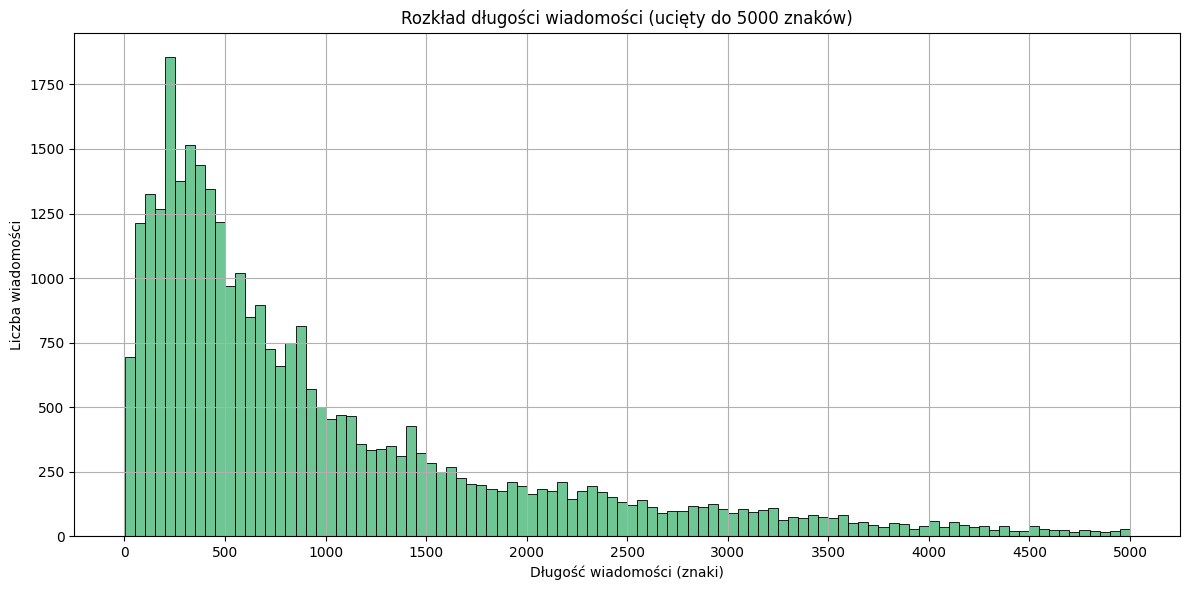

In [7]:
msg_lengths = df["Message"].fillna("").apply(len)

filtered_lengths = msg_lengths[msg_lengths < 5000]

plt.figure(figsize=(12, 6))
sns.histplot(filtered_lengths, bins=100, color="mediumseagreen")

plt.title("Rozkład długości wiadomości (ucięty do 5000 znaków)")
plt.xlabel("Długość wiadomości (znaki)")
plt.ylabel("Liczba wiadomości")
plt.xticks(np.arange(0, 5100, 500))
plt.grid(True)
plt.tight_layout()
plt.show()

Tokenizujemy temat i treść osobno.

In [8]:
max_len_subject = 20
max_len_message = 200
vocab_size = 10000

tokenizer_subj = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer_msg = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

tokenizer_subj.fit_on_texts(df["Subject"].fillna(""))
tokenizer_msg.fit_on_texts(df["Message"].fillna(""))

with open('tokenizer_subj.pkl', 'wb') as f:
    pickle.dump(tokenizer_subj, f)
with open('tokenizer_msg.pkl', 'wb') as f:
    pickle.dump(tokenizer_msg, f)

subj_seq = tokenizer_subj.texts_to_sequences(df["Subject"].fillna(""))
msg_seq = tokenizer_msg.texts_to_sequences(df["Message"].fillna(""))

subj_pad = pad_sequences(subj_seq, maxlen=max_len_subject, padding='post', truncating='post')
msg_pad = pad_sequences(msg_seq, maxlen=max_len_message, padding='post', truncating='post')

Dzielimy zbiór na część treningową i testową.

In [9]:
X_subj_train, X_subj_test, X_msg_train, X_msg_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    subj_pad, msg_pad, X_meta, df["Label"], test_size=0.2, random_state=42, stratify=df["Label"]
)

# Model CNN + MLP

Model łączy dwa podejścia:
- CNN (sieć konwolucyjna) - na danych tekstowych używamy warstw Embedding + Conv1D + MaxPooling1D
- MLP (perceptron wielowarstwowy) - po konwolucji łączymy metadane z danymi tekstowymi i używamy kilka razy Dense + Dropout

Tworzymy funkcję build_model, która będzie tworzyć modele z różnymi parametrami, w celu znalezienia najlepszego.

In [ ]:
def build_model(hp):
    input_subj = Input(shape=(max_len_subject,))
    input_msg = Input(shape=(max_len_message,))
    meta_input = Input(shape=(X_meta_train.shape[1],))
    
    embedding_dim = hp.Int('embedding_dim', 8, 64, step=8)

    x_subj = Embedding(vocab_size, embedding_dim)(input_subj)
    filters_subj = hp.Int('filters_subj', 16, 64, step=16)
    kernel_size_subj = hp.Choice('kernel_size_subj', [3, 5])
    x_subj = Conv1D(filters_subj, kernel_size_subj, activation='relu')(x_subj)
    x_subj = MaxPooling1D(2)(x_subj)
    x_subj = Flatten()(x_subj)

    x_msg = Embedding(vocab_size, embedding_dim)(input_msg)
    filters_msg = hp.Int('filters_msg', 32, 128, step=32)
    kernel_size_msg = hp.Choice('kernel_size_msg', [3, 5])
    x_msg = Conv1D(filters_msg, kernel_size_msg, activation='relu')(x_msg)
    x_msg = MaxPooling1D(2)(x_msg)
    x_msg = Flatten()(x_msg)

    text_features = Concatenate()([x_subj, x_msg])
    combined = Concatenate()([text_features, meta_input])

    dense1_units = hp.Int('dense1_units', 16, 64, step=16)
    combined = Dense(dense1_units, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(combined)

    dropout1_rate = hp.Float('dropout1_rate', 0.2, 0.5, step=0.1)
    combined = Dropout(dropout1_rate)(combined)

    dense2_units = hp.Int('dense2_units', 8, 32, step=8)
    combined = Dense(dense2_units, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(combined)
    dropout2_rate = hp.Float('dropout2_rate', 0, 0.4, step=0.1)
    combined = Dropout(dropout2_rate)(combined)

    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[input_subj, input_msg, meta_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model_wrapper():
    def model_fn(hp):
        return build_model(hp)
    return model_fn

Przy użyciu keras_tuner znajdujemy najlepsze parametry dla modelu. 

Dodajemy callbacks:
- ReduceLROnPlateau - delikatnie zmniejsza współczynnik uczenia, kiedy val_loss się ustabilizuje; w ten sposób osiągniemy jeszcze lepsze wyniki
- EarlyStopping - jeśli od kilku epok model się nie poprawia, to nie ma sensu kontynuować nauki

In [12]:
tuner = kt.RandomSearch(
    build_model_wrapper(),    
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=2,
    project_name='tuner_trials'
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=0
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

"""
tuner.search(
    [X_subj_train, X_msg_train, X_meta_train],
    y_train,
    epochs=40,
    validation_data=([X_subj_test, X_msg_test, X_meta_test], y_test),
    batch_size=256,
    callbacks=[early_stop, lr_scheduler]
)
"""

Reloading Tuner from .\tuner_trials\tuner0.json


'\ntuner.search(\n    [X_subj_train, X_msg_train, X_meta_train],\n    y_train,\n    epochs=40,\n    validation_data=([X_subj_test, X_msg_test, X_meta_test], y_test),\n    batch_size=256,\n    callbacks=[early_stop, lr_scheduler]\n)\n'

Trenujemy model.

In [16]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = build_model(best_hps)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

history = best_model.fit(
    [X_subj_train, X_msg_train, X_meta_train], y_train,
    validation_data=([X_subj_test, X_msg_test, X_meta_test], y_test),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, lr_scheduler],
)

Epoch 1/100
105/105 [==============================] - 2s 11ms/step - loss: 0.8276 - accuracy: 0.5060 - val_loss: 0.6970 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 2/100
105/105 [==============================] - 1s 8ms/step - loss: 0.6765 - accuracy: 0.5528 - val_loss: 0.2926 - val_accuracy: 0.8730 - lr: 0.0010
Epoch 3/100
105/105 [==============================] - 1s 8ms/step - loss: 0.2298 - accuracy: 0.9087 - val_loss: 0.1011 - val_accuracy: 0.9741 - lr: 0.0010
Epoch 4/100
105/105 [==============================] - 1s 8ms/step - loss: 0.1219 - accuracy: 0.9572 - val_loss: 0.0859 - val_accuracy: 0.9772 - lr: 0.0010
Epoch 5/100
105/105 [==============================] - 1s 8ms/step - loss: 0.0903 - accuracy: 0.9675 - val_loss: 0.0562 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 6/100
105/105 [==============================] - 1s 8ms/step - loss: 0.0624 - accuracy: 0.9744 - val_loss: 0.0464 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 7/100
105/105 [==============================] - 1s 8ms/s

# Wyniki i zapisanie modelu

In [17]:
pred_probs = best_model.predict([X_subj_test, X_msg_test, X_meta_test], verbose=0)
y_pred= (pred_probs > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'])

Accuracy: 0.9931024141550457
F1-score: 0.9931689931689932


Krzywe uczenia.

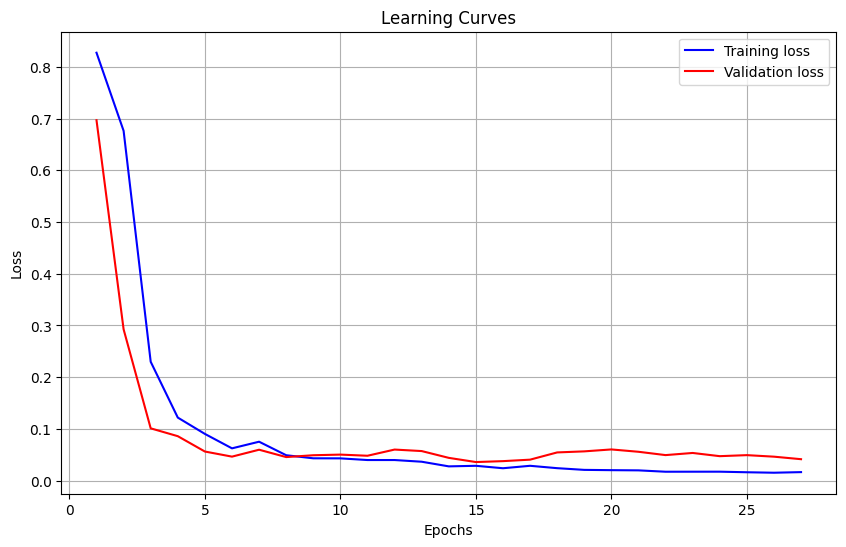

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

Mapa termiczna macierzy pomyłek.

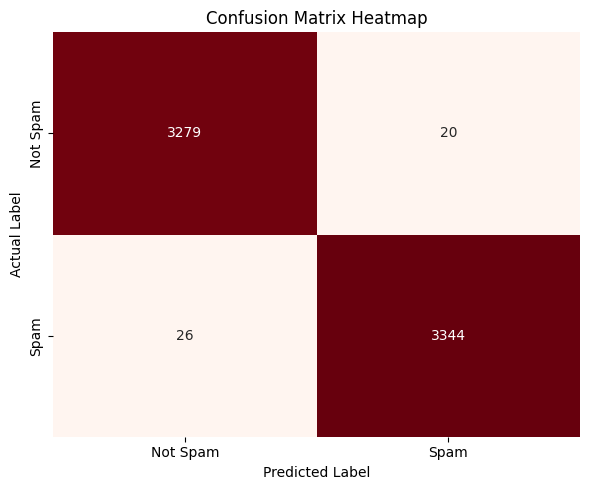

In [19]:
y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spam', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

Zapisujemy model.

In [20]:
best_model.save("spam_detector.h5")